## Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

1. Implement a simple forward model with no hidden layer (equivalent to logistic regression):
$y = softmax(\mathbf{W} x + b)$

1. build a `predict` function which returns the most probable class given an input $x$

1. build an `accuracy` function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

1. understand the method computing $\frac{d}{dW} -\log(softmax(Wx + b))$ for an $x$ and its corresponding expected output $y_{true}$

1. build a `train` function which uses the `grad` function output to update $\mathbf{W}$ and $b$

In this exercise we will take small images of hand written digits and classify them. This is a multi-class classification problem. We will use Logistic regression.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()

In [2]:
digits.data.shape

(1797, 64)

For each sample our model will output ten values. The probability it assigns for the image being in each of the ten classes. They should sum to one.

We express our desired output, the ground truth in a similar fashion by one-hot encoding it. So the class 3 will be represented as a vector `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes:

In [3]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [4]:
one_hot(10, 3)

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [5]:
one_hot(10, [3,2,1,0])

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
one_hot(10, [0, 4, 9, 1])

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Let's take a moment to take a look at the dataset before we start using it.

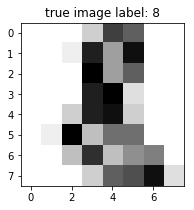

In [7]:
sample_index = 639 # change this to see different examples
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("true image label: %d" % digits.target[sample_index]);

### Preprocessing

- normalization (for more take a look at http://scikit-learn.org/stable/modules/preprocessing.html)
- train/test split

Why the need for preprocessing inputs? For neural networks it is important to have the min and max of all features on roughly the same scale. You do not want one feature from 0.0001 to 0.001 and another from 10 - 100. The result would be (amongst others) that the gradient involving one feature would be much larger than in the other direction.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Important to only use training data to learn the
# feature scaling. Training data simulates the future
# so we should not access any information from it.
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

In [9]:
Y_train = one_hot(10, y_train)
Y_train[:3]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [10]:
Y_test = one_hot(10, y_test)
Y_test[:3]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])

In [11]:
X_train.shape

(1527, 64)

Let's display one of the transformed samples (after feature standardization):

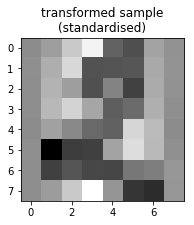

In [12]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(X_train[sample_index].reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("transformed sample\n(standardised)");

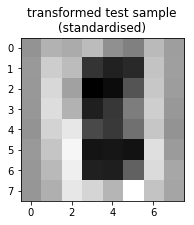

In [15]:
sample_index = 4
plt.figure(figsize=(3, 3))
plt.imshow(X_test[sample_index].reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("transformed test sample\n(standardised)");

The scaler object makes it possible to recover the original sample:

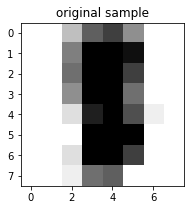

In [17]:
plt.figure(figsize=(3, 3))
plt.imshow(scaler.inverse_transform(X_train[sample_index]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("original sample");

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [14]:
def softmax1(X):
    s = np.sum(np.exp(X), keepdims=True)
    return np.exp(X) / s

softmax1(np.array([[10, 2, -3],
              [-1, 5, -20]]))

array([[  9.92957576e-01,   3.33100158e-04,   2.24441121e-06],
       [  1.65840803e-05,   6.69049552e-03,   9.29172262e-14]])

In [18]:
def softmax(X):
    return np.exp(X) / np.sum(np.exp(X), keepdims=True)

#x = np.array([[10, 2, -3],
#              [-1, 5, -20]])
# compare these steps in building up the softmax function
#x / np.sum(x, axis=-1, keepdims=True)
#x / np.sum(x, axis=-1, keepdims=True)
#np.sum(x, axis=-1)
#np.sum(x)

In [19]:
#X = np.random.random(size=(100000, 1000))

In [20]:
#%%timeit
#softmax1(X)

In [21]:
#%%timeit
#softmax2(X)

Make sure that this works one vector at a time (and check that the components sum to one):

In [22]:
print(softmax([10, 2, -3]))

[  9.99662391e-01   3.35349373e-04   2.25956630e-06]


Note that a naive implementation of softmax might not be able process a batch of activations in a single call (but we need that):

In [23]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))
# check the keepdims argument of `np.sum` for a hint

[[  9.92957576e-01   3.33100158e-04   2.24441121e-06]
 [  1.65840803e-05   6.69049552e-03   9.29172262e-14]]


## Loss

This is a multi-class classification problem. The loss function we will use unfortunately has many names that are used interchangably. You can also find many simplified definitions for the two class case that do not note that they are simplifications. For example [wikipedia](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression) has a nice worked example but only a small note pointing out that this is for two classes only. Maybe read this first, then try and extend it to multiple classes using the notation from the beginning of that wikipedia entry.

We will use "log loss", "cross entropy", or even "categorical crossentropy".

The general expression for the log loss of **one sample** is:
$$
\ell = - \sum_k \mathbf{1}_{k=y} log(p_k)
$$

For a problem with $k$ classes, where $y$ denotes the true class, and $p_k$ the probability the network predicts for class $k$. $\mathbf{1}$ is the indicator function, a clever way of saying "zero if `k!=y`, one otherwise". The loss over a complete training (or testing or validation) set of samples is the sum(!) of $\ell$ for each sample.

Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood. For this problem we are using the "log loss" loss function (also known as cross-entropy).

This `nll` is a scalar computed using all samples in our training set. The likelihood measures how likely something is. Using the term "likelihood" instead of probability because the likelihood does not have to be a probability.

$$L = P_1 \cdot P_2 \cdot P_3 \cdot ... $$

However multiplying lots of small numbers together is a numerical disaster. Use $\log(ab) = \log(a) + log(b)$ to convert the product into a sum (hence the name log-likelihood). The negative just means we multiply everything by minus one.

In [24]:
np.atleast_2d([1,2,3]), np.array([1,2,3])

(array([[1, 2, 3]]), array([1, 2, 3]))

In [25]:
EPSILON = 1e-8 # this is here to give you a hint on how to deal with the case when y_pred=0

def nll(Y_true, Y_pred):
    #Y_true = np.atleast_2d(Y_true)
    #Y_pred = np.atleast_2d(Y_pred)
    
    # alternative way to prevent log(0)
    #Y_pred[Y_pred==0] = EPSILON
    # or use np.clip()
    #Y_pred = np.clip(Y_pred, EPSILON, 1.)
    
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.0100503257525


In [26]:
a = np.array([-1, 2, 0.5])
#a_ = np.clip(a, EPSILON, 1.)
np.clip(a, EPSILON, 1., out=a)
print(a)

[  1.00000000e-08   1.00000000e+00   5.00000000e-01]


Check that the `nll` of a very confident yet incorrect prediction is a much higher positive number:

In [27]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.60516918599


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be passed in as 2D arrays:

In [28]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.0033501019175


Finally we have all the ingredients for training a logistic regression model using gradient descent.

Let's study it one sample at a time. To help understand how to implement the various methods here do read on to see how it will be used. Then start implementing things that you can test straight away. For example the forward pass can be tested before trying to train the model. You can also check the computation of the accuracy with a randomly initialised model as you know what its accuracy should be.

In [54]:
class LogisticRegression():
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        # TODO: compute normalised scores for each class, this is the output
        # of the softmax()
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)

    def predict(self, X):
        # TODO: for each sample in X return the predicted class
        # translate the class probabilities of each sample into a human
        # friendly representation using integers
        #return np.argmax(self.forward(X), axis=-1)
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        # TODO: compute gradient with respect to W and b for a sample x
        # and the true label y_true
        # If you are confident in your linear algebra skills attempt to
        # write this from scratch.
        # Notes on how to do it: https://web.stanford.edu/class/archive/cs/cs109/cs109.1178/lectureHandouts/220-logistic-regression.pdf
        # In particular the last section
        y_pred = self.forward(x)

        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # TODO: compute one step of traditional gradient descent update without momentum
        # and update W and b
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate *grads["W"]
        self.b = self.b - learning_rate *grads["b"]
        
    def loss(self, x, y):
        # TODO: use `nll` to compute the loss for the sample x with true label y
        y_true = one_hot(self.output_size, y)
        scores = self.forward(x)
        return nll(y_true, scores)

    def accuracy(self, X, y):
        # TODO: compute accuracy for samples X with true labels y
        return np.sum(y == self.predict(X)) / X.shape[0]

In [30]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]

In [62]:
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))
# Question: do you think the accuracy makes sense?

Evaluation of the untrained model:
train loss: 9.7157, train acc: 0.115, test acc: 0.130


8


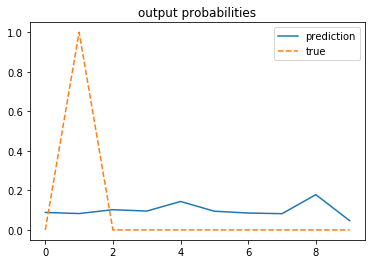

In [63]:
# Test the untrained model on an example
sample_idx = 3
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))

In [64]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 9.6834, train acc: 0.128, test acc: 0.152
Update #100, train loss: 8.6546, train acc: 0.732, test acc: 0.781
Update #200, train loss: 8.2746, train acc: 0.870, test acc: 0.904
Update #300, train loss: 8.1451, train acc: 0.901, test acc: 0.930
Update #400, train loss: 8.1899, train acc: 0.902, test acc: 0.937
Update #500, train loss: 8.1472, train acc: 0.921, test acc: 0.941
Update #600, train loss: 10.0956, train acc: 0.931, test acc: 0.941
Update #700, train loss: 10.2379, train acc: 0.931, test acc: 0.956
Update #800, train loss: 10.1417, train acc: 0.935, test acc: 0.963
Update #900, train loss: 10.1805, train acc: 0.941, test acc: 0.952
Update #1000, train loss: 10.5818, train acc: 0.949, test acc: 0.956
Update #1100, train loss: 10.2935, train acc: 0.949, test acc: 0.967
Update #1200, train loss: 10.2295, train acc: 0.953, test acc: 0.970
Update #1300, train loss: 10.0917, train acc: 0.950, test acc: 0.956
Update #1400, train loss: 10.0689, train acc: 0.957,

In [ ]:
# Evaluate the trained model on an example
sample_idx = 899
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))

Questions:

* can you find examples that are mispredicted, is there a pattern to the wrong predictions?
* visualise these samples and their predicted classes
* plot the [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to find classes that are hard to separate (maybe eight vs nine?)
* do things improve with training for more epochs?
* experiment with different values of the learning rate. Can you accelerate learning? What happens for very large values of the learning rate? Very small ones?
* convert the training setup to use stochastic gradient descent, does this change things?
* what is the optimal number of epochs to train for? Why? Plot the value of the loss (on the training and on the testing dataset) as a function of the epoch. Is there a sweet spot?